## Loading the dependencies

In [71]:
import cv2 as cv
import numpy as np
import svg_points as svg
import matplotlib.pyplot as plt
import math
import time
import json

## Declaring global constants

In [72]:
# Paths
OBJ_ID         = "obj04" 
OBJ_CONFIG     = json.load(open(f"../config/{OBJ_ID}.json"))
OBJ_VIDEO_PATH = f"../data/{OBJ_ID}.mp4" 
OBJ_MASK_PATH  = f"../processed/{OBJ_ID}/masks.npy"
PLY_NOCOL_PATH = f"../processed/{OBJ_ID}/no_col.ply"
PLY_WTCOL_PATH = f"../processed/{OBJ_ID}/wt_col.ply"     

CAM_INTRINSIC_PATH  = "../processed/K.npy"
CAM_DISTORTION_PATH = "../processed/dist.npy"

# Region of interest for marker analysis
MARKER_ROI_LEFT_COL  = 1100
MARKER_ROI_RIGHT_COL = 1600
MARKER_ROI_UPPER_ROW = 0
MARKER_ROI_LOWER_ROW = 1080

# Cup relative coordinates respect to ROI
CUP_ROI_LEFT_COL     = 0
CUP_ROI_RIGHT_COL    = 300
CUP_ROI_UPPER_ROW    = 350
CUP_ROI_LOWER_ROW    = 730   

# Standard sharpening kernel
SHARPENING_KERNEL    = np.array([[0, -1, 0],
                              [-1, 5, -1],
                              [0, -1, 0]])
# Marker contouring params
MARKER_THRESH_POLY_DP = 0.009
MARKER_MIN_AREA       = 1500
MARKER_SUBPIX_TERM    = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 50, 0.001)
MARKER_SUBPIX_WINDOW  = (3,3)

# Marker detection
MIN_MARKERS          = 6 

# Space carving
VOXEL_SIZE           = 1.25

## Performing the analysis

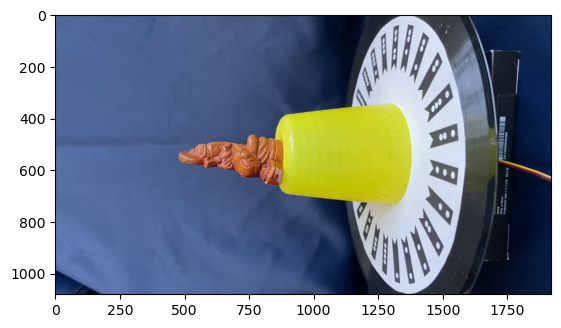

In [73]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)
    
assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)

plt.imshow(rgb_frame)

### 1. ROI cutting

In order to make the marker detection easy and performant, we only focus on a defined portion of the image, called the Region of Intererest.

In [74]:
def roi_cut (frame):

    ROI = frame[MARKER_ROI_UPPER_ROW:MARKER_ROI_LOWER_ROW, MARKER_ROI_LEFT_COL:MARKER_ROI_RIGHT_COL]
   
    return ROI    

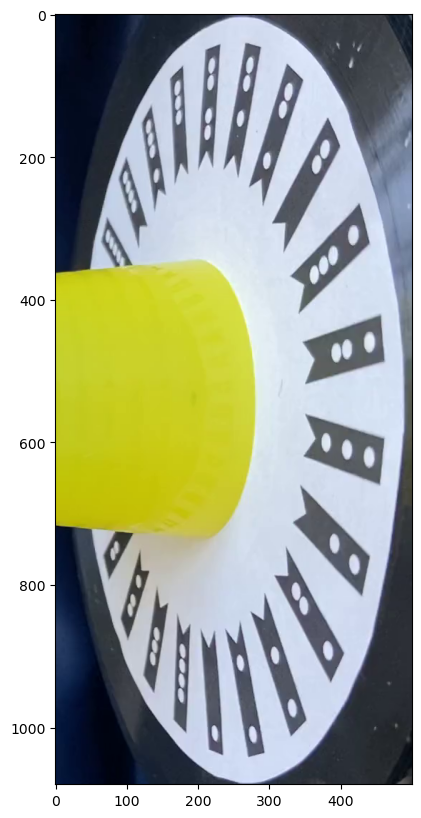

In [75]:
cloned = rgb_frame.copy()
ROI = roi_cut(cloned)
plt.figure(figsize=(10,10))
plt.imshow(ROI)

### 2. Intensity correction

In order to improve marker detection and pose estimate we sharpen the image. This will help thresholding but also corner detection

In [76]:
def intensity_correct (frame):
    sharpened = cv.filter2D(src=frame, ddepth=-1, kernel=SHARPENING_KERNEL)
    return sharpened

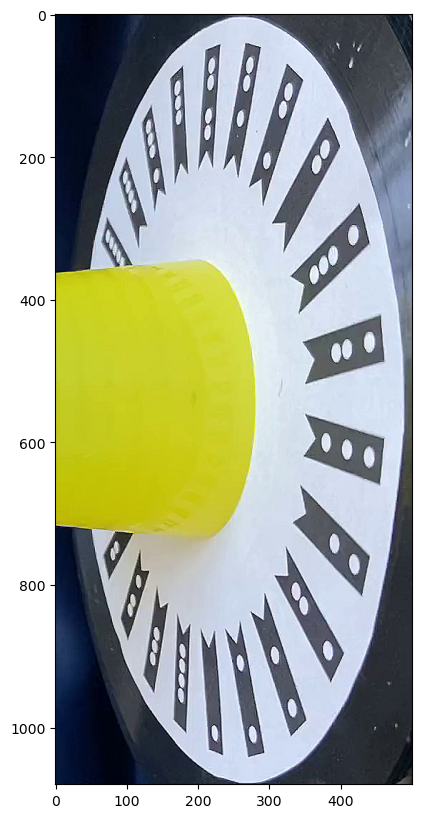

In [77]:
sharpened = intensity_correct(ROI)
plt.figure( figsize=(10,10))
plt.imshow(sharpened)

### 3. Thresholding

In order to find the shape of each marker, we need to threshold the image to a black and white representation. Binary thresholding is enough for our purposes. We won't perform any analysis on the cup, so we can fill its bounding rectangle with white pixels (this will be useful also for the contour detection process)

In [78]:
def threshold (frame):
    gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)
    ret, thresholded = cv.threshold(gray, 172, 255, cv.THRESH_BINARY)
    thresholded[CUP_ROI_UPPER_ROW:CUP_ROI_LOWER_ROW, CUP_ROI_LEFT_COL:CUP_ROI_RIGHT_COL] = 255
    return thresholded

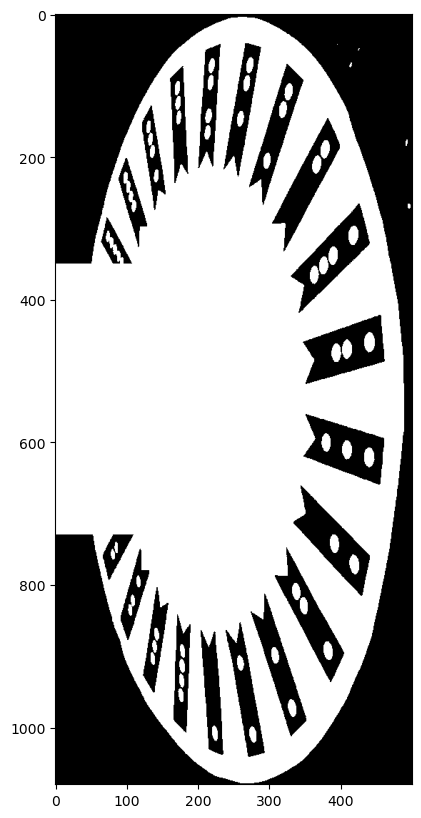

In [79]:
thresholded = threshold(ROI)
plt.figure( figsize=(10,10))
plt.imshow(thresholded, cmap = 'gray')

### 5. Detect markers

How can we detect markers? We can use a simple pipeline to do that:

1. Find contours using the RETR_CCOMP flag. With this flag we look for a two level contours hierarchy. Thanks to previous segmentation and cup filling, we guarantee to have just one external contour, which is the one of the disc. Internal contours are potentials markers
<br>
2. For each potential marker, approximate its shape to a polygon using approxPolyDP. Then, perform two tests:
    
    2.1 Is contour really a marker? Only contours big enough and with 5 corners are likely to be markers
    
    2.2 If it is, is the contour likely to be undistorted? Only contours far enough from the cup are guarantee to be so
<br>
3. For each marker, use cornerSubPix in order to adjust with sub-pixel accuracy the corners locations



In [80]:
reference = (0, 540)

def contour_is_marker (cnt_poly):
    area   = cv.contourArea(cnt_poly)
    return area > MARKER_MIN_AREA and (len(cnt_poly) == 5)

def contour_is_safe (cnt_poly):
    M = cv.moments(cnt_poly)
    cnt_center = np.array((int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])))
    d = cv.norm(reference - cnt_center)
    return d > 280
    

def get_markers (thresholded):
    contours, h = cv.findContours(thresholded, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    markers = []
    
    for i, cnt in enumerate(contours):
        p = h[0][i][3]
        if p != -1:
            # We want our detection to be as accurate as possible, so we use a tight approximation: 
            # For this reason MARKER_THRESH_POLY_DP has a small value
            approx_dp = cv.approxPolyDP(cnt, MARKER_THRESH_POLY_DP * cv.arcLength(cnt, True), True) 
            if contour_is_marker(approx_dp) and contour_is_safe(approx_dp):
                # Test passed: marker detected
                corners = cv.cornerSubPix(thresholded, np.squeeze(approx_dp).astype('float32'), MARKER_SUBPIX_WINDOW, (-1,-1), MARKER_SUBPIX_TERM)
                markers.append(corners)
       
    return np.array(markers)

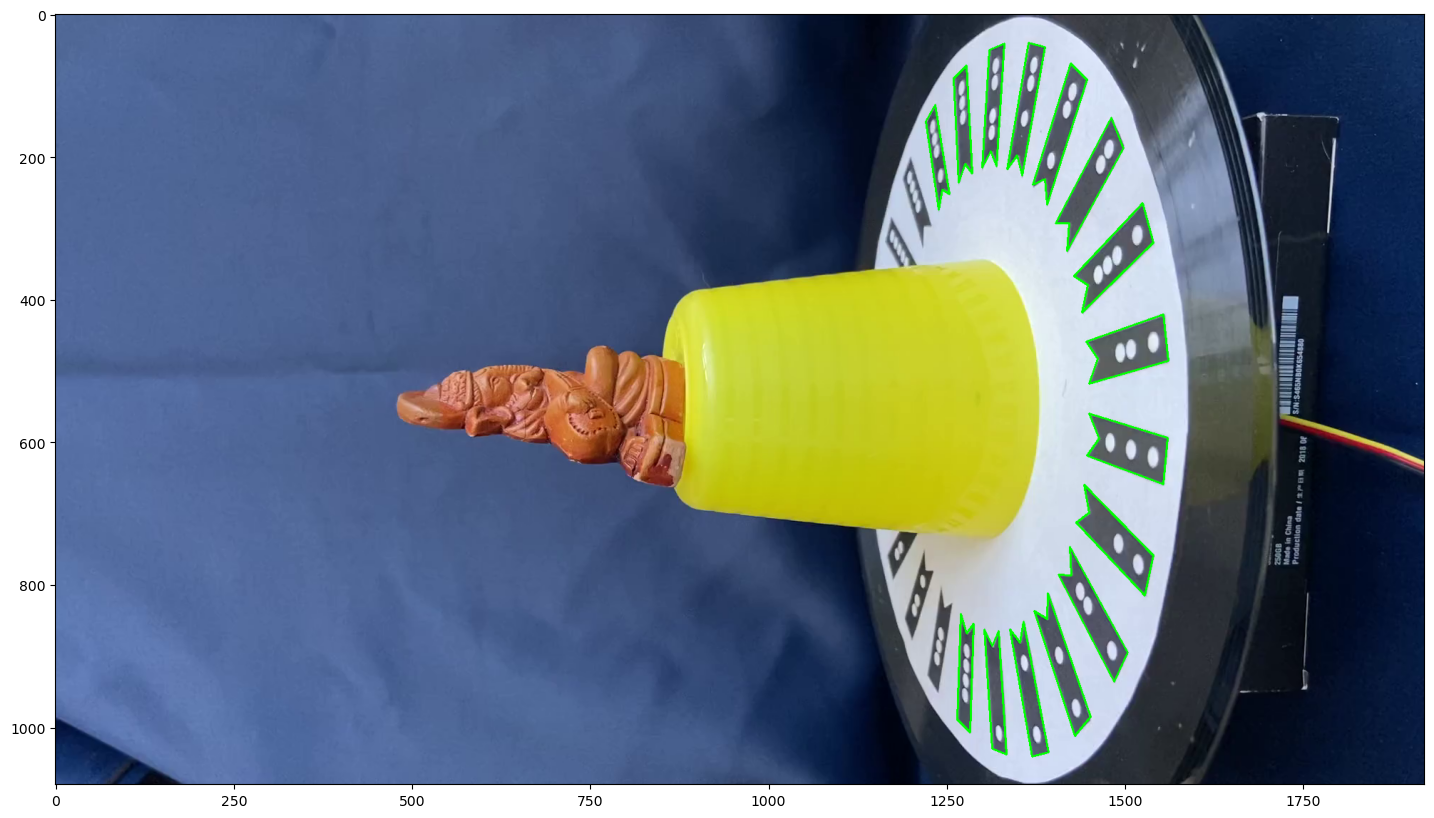

In [81]:
f = rgb_frame.copy()
markers = get_markers(thresholded)

contoured = cv.drawContours(f,[marker.astype('int32') for marker in markers], -1, (0, 255, 0), 2, offset=(1100, 0))
        
plt.figure(figsize=(20,10) ) 
plt.imshow(contoured)

As we can see, the approximated contours well adhere to the marker borders. However, some makers are excluded from the contouring. This is because we use tigher contour approximation. We want marker shapes to be accurate, even if that means lower recall

### 6. Corner labeling

In order to recover markers' encoding, we need to find the orientation of each marker. Each marker is defined by a set of corners, sorted in clockwise order from the top external point. The goal is to find the position of these corners in the image (corner labeling). A simple way to do so is to convert detected marker corners coordinates from cartesian to polar. In this way, corners can be classified by the distance and the angle they form with the disc center.

More specifically, the algorithm works as follow:
1. Convert each corner to polar coordinates
2. Sort converted corners by their distance from the center in increasing order. Split them in two groups: internal and the external corners
3. For each group, sort its corners by the angle in increasing order.
4. Now we can recover the corner positions in the image by corresponding the sorted corners with the reference ones

In [82]:
def cart2pol(point):
    x, y = point
    rho  = np.sqrt(x**2 + y**2)
    phi  = math.degrees(np.arctan2(y, x))
    return(rho, phi)

def pol2cart(point):
    rho, phi = point
    x = rho * np.cos(math.radians(phi))
    y = rho * np.sin(math.radians(phi))
    return(x, y)

def sort_marker_points (center, points):
    
    shifted_pts = list(map(lambda pt: (pt[0] - center[0], pt[1] - center[1]), points))
    polar_pts   = list(map(cart2pol, shifted_pts))
        
    polar_pts    = np.array(polar_pts)
    polar_by_rho = polar_pts[polar_pts[:, 0].argsort()]
    
    internal_pts = np.array(polar_by_rho[:3])
    external_pts = np.array(polar_by_rho[3:])
    
    internal_by_phi = internal_pts[internal_pts[:, 1].argsort()]
    external_by_phi = external_pts[external_pts[:, 1].argsort()]
    
    A, B    = external_by_phi
    C, D, E = internal_by_phi[::-1]
    
    cart_pts      = list(map(pol2cart, [A, B, C, D, E]))
    unshifted_pts = list(map(lambda pt: (pt[0] + center[0], pt[1] + center[1]), cart_pts)) 
    
    return np.array(unshifted_pts)

We project the labeled corners in order to spot wrong detections

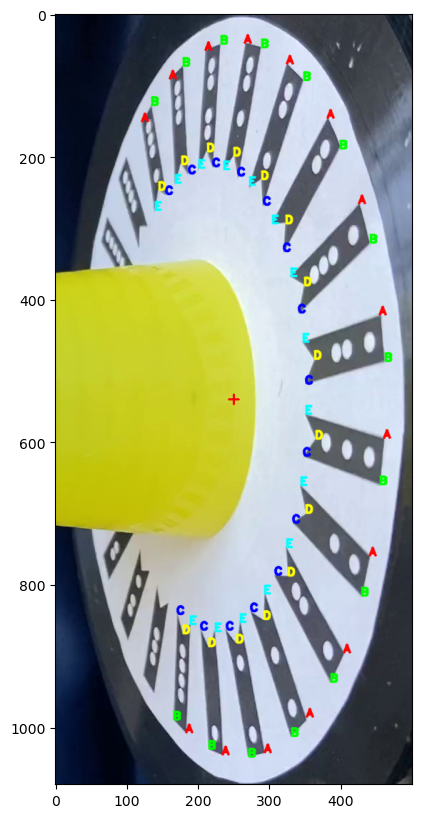

In [83]:
res = ROI.copy() 
CX, CY = ROI.shape[1] / 2, ROI.shape[0] / 2
letters = ['A', 'B', 'C', 'D', 'E']
colors  = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

cv.drawMarker(res, (int(CX), int(CY)), (255, 0, 0), cv.MARKER_CROSS, 15, 2)

for marker in markers:
    sorted_pts = sort_marker_points((CX, CY), marker)
    for i, pt in enumerate(sorted_pts):
        cv.putText(res, letters[i], pt.astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.5, colors[i], 2, cv.LINE_AA)
        
plt.figure(figsize=(10,10) ) 
plt.imshow(res)      

Corner labeling seems to work fine for each detected marker

### 7. Recover marker value

At this point we have enough informations to recover the marker value. What we need to do is to find an algorithm able to do it. We can use a very simple strategy:

1. For each marker pick two relevant points: the external side middle point and the concave corner
2. Compute the direction of the vector starting from the concave corner and terminating on the middle point
3. Scale the vector by a factor of 6, because each marker is encoded with 6 internal points
4. Increment the length of the vector until it reaches the external middle point
5. For each crossed internal point, detects if it represents a 1 or a 0 and append its encoding to a binary sequence
6. Represents the binary sequence with base 10

In [84]:
def bin2dec (bin_str):
    return int(bin_str[::-1], 2)

def decode_marker(sorted_pts, thresholded):

    bin_str   = ""
    centroids = []
    
    c_x, c_y   = sorted_pts[3]    
    ext1, ext2 = sorted_pts[:2] 
    
    m_x = (ext1[0] + ext2[0]) / 2 
    m_y = (ext1[1] + ext2[1]) / 2
    
    vec_x = (m_x - c_x) / 6
    vec_y = (m_y - c_y) / 6

    for i in range(1, 6, 1):
        
        x = c_x + vec_x * i
        
        y = c_y + vec_y * i
  
        value = "0" if thresholded[int(y)][int(x)] == 255 else "1"
        
        bin_str += value
    
        centroids.append({
            "center": (int(x), int(y)),
            "value": value 
        })    
    
    
    return bin2dec(bin_str), centroids

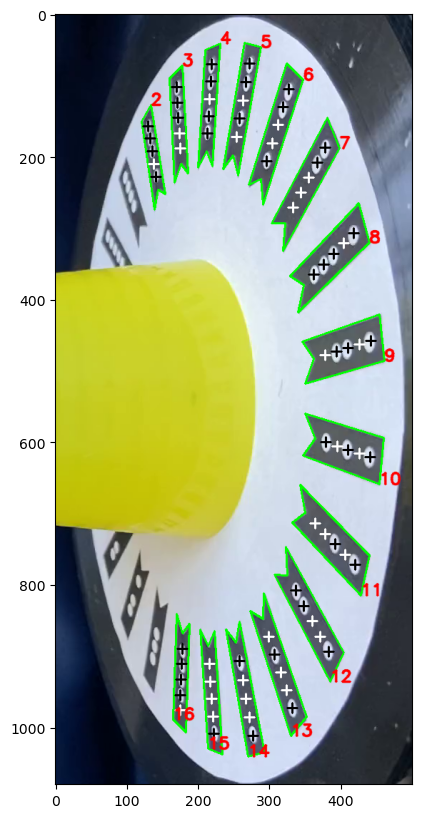

In [85]:
res = ROI.copy() 

for marker in markers:

    sorted_pts = sort_marker_points((CX, CY), marker)
    
    value, centroids = decode_marker(sorted_pts, thresholded)
    
    cv.drawContours(res, [marker.astype('int32')], -1, (0, 255, 0), 2)
    
    for c in centroids:
        cv.drawMarker(res, c["center"], (0, 0, 0) if c["value"] == "0" else (255, 255, 255), cv.MARKER_CROSS, 15, 2)
    
    cv.putText(res, str(value), sorted_pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    

plt.figure(figsize=(10,10) ) 
plt.imshow(res)  

Detection seems to work. Each detected marker is correctly decoded.

### 8. Testing everything

Let's wrap the required operations needed to recover the marker into a single function. We want to see if our procedure has a reasonable processing time (ideally, the frame rate should not decrease below 30fps) and has a consistent behaviour.

In [86]:
def marker_detect (frame, offset = (0,0)):
    
    roi     = roi_cut(frame)
    roi_ic  = intensity_correct(roi)
    roi_th  = threshold(roi_ic)
    
    markers = get_markers(roi_th)
    center  = (roi.shape[1] / 2, roi.shape[0] / 2)
    
    detected = []
    
    for marker in markers:
        sorted_pts = sort_marker_points (center, marker)
        value, centroids = decode_marker(sorted_pts, roi_th)
        
        offset_pts = []
        for pt in sorted_pts:
            x = pt[0] + offset[0]
            y = pt[1] + offset[1]
            offset_pts.append((x,y))
        
        offset_centroids = []
        for c in centroids:
            x, y = c["center"]
            x = x + offset[0]
            y = y + offset[1]
            offset_centroids.append({"center": (x, y), "value": c["value"]})
        
        detected.append((np.array(offset_pts), value, np.array(offset_centroids)))
        
    return roi, np.array(detected)

Let's test the function on the entire video. We will look for possible errors and FPS.

In [104]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    start         = time.time()
    roi, detected = marker_detect(frame, offset=(1100, 0))
    end           = time.time()
        
    for marker in detected:
    
        sorted_pts, value, centroids = marker
    
        cv.drawContours(frame, [sorted_pts.astype('int32')], -1, (0, 255, 0), 2)
    
        for c in centroids:
            cv.drawMarker(frame, c["center"], (0, 0, 0) if c["value"] == "0" else (255, 255, 255), cv.MARKER_CROSS, 15, 2)
    
        cv.putText(frame, str(value), sorted_pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
    
    fps = int(1 / (end - start))
    
    cv.putText(frame, "FPS: " + str(fps), (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
    
    cv.imshow("frame", frame)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        

cap.release()
cv.destroyAllWindows()

/tmp/ipykernel_14593/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)


### 10. Recover camera pose

Now we are able to recover the camera pose, i.e. its extrinsic parameters. To do so, we will use the _solvePnP_ function, using the intrinsic paramenters and comparing the detected markers frame positions with the respective coordinates in the 3D world space. Before performing the computation, we need to be sure that detected marker are correctly identified. To achive a good level of confidence, we will filter the detected markers with two filters functions

#### 10.1 Marker filtering 
The first filter removes every marker which has been detected more than once in the frame. In fact, we are not able to deterministically tell which of the detections is correct, assuming that at least one detection is not wrong

In [88]:
def remove_same (arr):
    """
    Removes every occurence of not unique elements in the array
    """
    i = 0
    c = []
    
    while i < len(arr):
        pivot = arr[i]
        
        j = 1
        while (i + j < len(arr) and arr[i + j] == pivot):
            j += 1
        
        # Is the element unique? 
        if (j == 1):
            c.append(i)
        
        i += j
        
    return c


def remove_same_markers(sorted_markers):
    
    cleaned_markers = []
    cleaned_args    = remove_same(sorted_markers[:, 1])
    
    for arg in cleaned_args:
        cleaned_markers.append(sorted_markers[arg])
    
    return np.array(cleaned_markers)
    

The second filter only selects markers which appears in a strictly increasing sequence. The probability of having consecutive wrong detections lowers on long sequences, so we pick the longest one

In [105]:

def long_incr_seq (arr):
    """
    Returns the longest strictly increasing sequence in a incresing sorted the array
    Ex: [1,2,3,5,6,90,91] -> [1,2,3]
    """
    cur_len = 1
    max_len = 1
    max_end = 0
    end     = 0
    
    for i, el in enumerate(arr[1:]):
        i = i + 1
        if (el == arr[i - 1] + 1):
            end = i
            cur_len = cur_len + 1
            
            max_end = end if cur_len > max_len else max_end
            max_len = cur_len if cur_len > max_len else max_len
            
        else:
            cur_len = 1
    
    return  max_end - (max_len - 1), max_end, max_len

def get_increasing_markers (sorted_markers):
    start, end, length = long_incr_seq(sorted_markers[:, 1])
    good_markers = sorted_markers[start:end + 1]
    return good_markers

We wrap the filters into a single function. We consider the detection failed if the number of filtered markers is below MIN_MARKERS

In [ ]:
def pick_good_markers (markers):
    
    sorted_markers = markers[markers[:, 1].argsort()]

    # Remove duplicated detections
    cleaned_markers = remove_same_markers(sorted_markers)
    
    # Only keep markers which are likely to be correctly predicted
    incr_markers    = get_increasing_markers(cleaned_markers)
    
    if (len(incr_markers) >= MIN_MARKERS):
        return True, incr_markers
    else:
        return False, incr_markers

#### 10.2 Camera pose recovery


In [106]:
# Intrinsic parameters
K  = np.load(CAM_INTRINSIC_PATH)
dist_coeffs = np.load(CAM_DISTORTION_PATH)

# The marker coordinates in the world space
svg_pts = svg.SVGPoints()

def recover_camera_pose (markers):
    
    img_pts   = []
    ref_pts   = []
    
    for marker in markers:
            
        marker_img_pts, value, _ = marker
        marker_ref_pts           = svg_pts.get_reference_points(value)
            
        img_pts.append(marker_img_pts)
        ref_pts.append(marker_ref_pts)
            
    img_pts = np.array(img_pts).flatten().reshape((-1, 2))
    ref_pts = np.array(ref_pts).flatten().reshape((-1, 3))

    
    ok, Ri, Ti  = cv.solvePnP(ref_pts, img_pts, K, dist_coeffs, flags = cv.SOLVEPNP_IPPE)
    
    return Ri, Ti, ref_pts

#### 10.3 Camera pose testing

Now we are able to test the pipeline. For each frame, we will store the recovered pose and perform backprojection using the recovered params. Backprojection will be useful for estimating how wrong is the camera pose from the real one. We will quantize the backprojection error through RMSE. This will also be helpful for carving.

In [108]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

fpses = []
frames = 0

RMSES = []
POSES = [] 

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    if (True):
        start             = time.time()
        roi, markers      = marker_detect(frame, offset=(1100, 0))
        det, good_markers = pick_good_markers(markers)
        
        if (det):
            r_vec, t_vec, ref_pts = recover_camera_pose(good_markers)
            end             = time.time()

            proj_pts, jacobian = cv.projectPoints(ref_pts, r_vec, t_vec, K, dist_coeffs)
            proj_pts = np.squeeze(proj_pts)

            points     = np.array([marker[0] for marker in good_markers]).reshape((-1, 2))
            points_hat = proj_pts
            
            for pt in proj_pts:
                cv.circle(frame, (int(pt[0]), int(pt[1])), 3, (0,0,255), -1)

            for marker in good_markers:
                pts, value, c = marker
                for pt in pts:
                    cv.circle(frame, (int(pt[0]), int(pt[1])), 3, (255,0,0), -1)
                cv.putText(frame, str(value), pts[1].astype('int32'), cv.FONT_HERSHEY_SIMPLEX, 0.75, (255, 0, 0), 2, cv.LINE_AA)
            
            fps = int(1 / (end - start))
            rmse = math.sqrt(np.square(np.subtract(points, points_hat)).mean())
        
            fpses.append(fps)
            frames += 1
            
            cv.putText(frame, "FPS: " + str(fps), (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
            cv.putText(frame, "RMSE: " + str(round(rmse, 2)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
            
            POSES.append((r_vec, t_vec))
            RMSES.append(rmse)
            
        else:
            POSES.append(None)
            RMSES.append(None)

    cv.imshow("frame", frame)
    
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break

POSES = np.array(POSES)
RMSES = np.array(RMSES)

cap.release()
cv.destroyAllWindows()

/tmp/ipykernel_14593/3928047572.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return roi, np.array(detected)
/tmp/ipykernel_14593/2100072406.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  POSES = np.array(POSES)


#### 10.3 Backprojection accuracy

Let's see how well our pipeline performs. We plot the RMSE frequencies on a histogram. The goal is to have the majority of the values below 1 (the backprojection error is below 1 pixel)

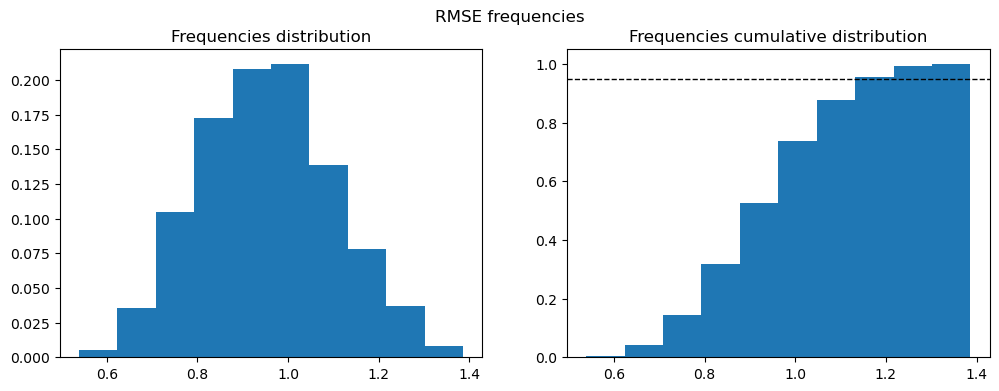

In [130]:
def none_filter (x):
    return x != None

rmses = RMSES[none_filter(RMSES)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

fig.suptitle('RMSE frequencies')
ax1.set_title('Frequencies distribution')
ax1.hist(rmses, weights=np.ones_like(rmses) / len(rmses))
ax2.set_title('Frequencies cumulative distribution')
ax2.hist(rmses, weights=np.ones_like(rmses) / len(rmses),  cumulative=True)
ax2.axhline(0.95, color='k', linestyle='dashed', linewidth=1, )

Backprojection graphs show that camera position recovery is accurate enough for space carving, the 90% of the backprojections have a RMSE below 1.2

### 11. Projecting the voxel grid

In order to perform space carving, we need to project the voxel grid. Given the high number of voxels to be projected, we will also look for a performant way to project them

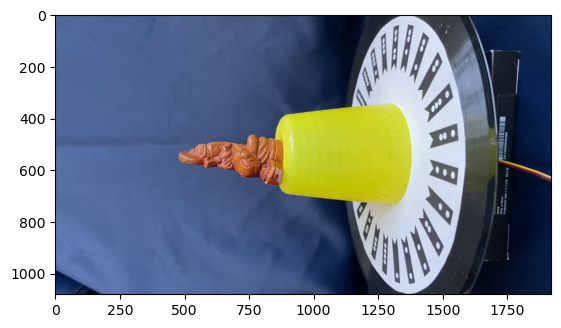

In [93]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

assert cap.isOpened(), "Unable to acquire video stream"
    
ret, bgr_frame = cap.read()

cap.release()

rgb_frame = cv.cvtColor(bgr_frame, cv.COLOR_BGR2RGB)


plt.imshow(rgb_frame)

#### 11.1 Build the voxel grid

The voxel grid is a parallelepiped with user defined depth, width and height. Voxel coordinates in space depends by the center point of the plane in which the object is placed. The number of voxels inside the voxel grid depends by the voxel size. The voxel grid will will be represented as an array containing the voxels' centers coordinates and the respective color, initially set to black

In [94]:
def build_voxel_grid (bp, grid_d, grid_w, grid_h, grid_res):
    
    voxel_grid = []
    
    offset_x = bp[0] - int(grid_d / 2)
    offset_y = bp[1] - int(grid_w / 2)
    offset_z = bp[2]
        
    x_acc = offset_x

    while x_acc < offset_x + grid_d:
        y_acc = offset_y
        while y_acc < offset_y + grid_w:
            z_acc = offset_z
            while z_acc < offset_z + grid_h:
                voxel_grid.append({
                    "coordinates": np.array([x_acc, y_acc, z_acc]),
                    "color": (0,0,0)
                    })
                z_acc += grid_res
            y_acc += grid_res
        x_acc += grid_res

    return np.array(voxel_grid)

In [126]:
f = rgb_frame.copy()

r_vec, t_vec = POSES[0]

P = getProjectionMatrix(r_vec, t_vec, K)

voxel_grid = build_voxel_grid(
    OBJ_CONFIG["carving"]["voxelgrid_origin"], 
    OBJ_CONFIG["carving"]["voxelgrid_d"],
    OBJ_CONFIG["carving"]["voxelgrid_w"],
    OBJ_CONFIG["carving"]["voxelgrid_h"],
    VOXEL_SIZE
)

#### 11.2 Handmade projection using projection matrix

Let's see how well performs handmade projection. For each voxel, transform its coordinates from world space to camera space using the projection matrix, then project the obtained points on the 2D image plane

In [127]:
def getProjectionMatrix (r_vec, t_vec, K):
    
    R, _ = cv.Rodrigues(r_vec)
    T    = t_vec
    
    extrinsic = np.zeros(shape=(3,4))
    extrinsic[:3, :3] = R
    extrinsic[:, 3:]  = T

    return K @ extrinsic

    
def from3Dto2D (pt, pm):
    
    ptHom = np.append(pt, 1.0)
    
    pt2D  = pm @ ptHom
    z     = pt2D[-1]
    pt2D  = pt2D / z
    
    return pt2D[:-1]

Projection done in 4.06 seconds


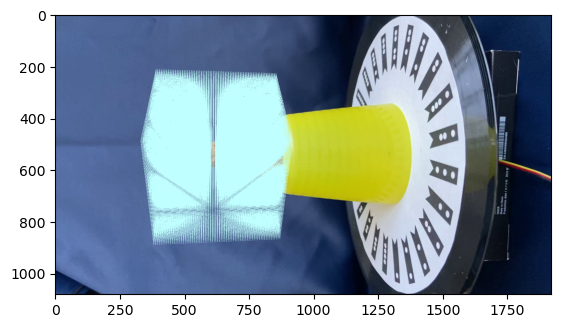

In [128]:
start = time.time()

for voxel in voxel_grid:
    proj_p = from3Dto2D(voxel["coordinates"], P)
    cv.circle(f, (int(proj_p[0]), int(proj_p[1])), 1, (192,255,255), -1)

delta = round(time.time() - start, 2)
    
plt.imshow(f)
print("Projection done in", delta, "seconds")

#### 11.2 Projection using opencv projectPoints

Let's see if the opencv _projectPoints_ function is faster than our implementation

Projection done in 0.96 seconds


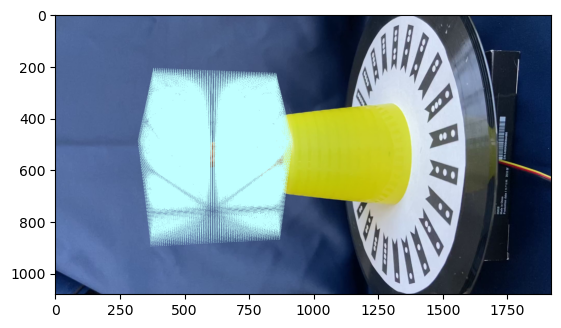

In [129]:
f = rgb_frame.copy() 

start = time.time()

voxels = np.array([v["coordinates"] for v in voxel_grid]).astype('float32')

projected, _ = cv.projectPoints(voxels, r_vec, t_vec, K, dist_coeffs)

for proj_p in np.squeeze(projected):
    cv.circle(f, (int(proj_p[0]), int(proj_p[1])), 1, (192,255,255), -1)

delta = round(time.time() - start, 2)
    
plt.imshow(f)
print("Projection done in", delta, "seconds")

_projectPoints_ seems to be around 4 times faster than handmade projection

### 12. Space carving

Now we can perform space carving. We skip frames whose marker detection has an RMSE over 1.3 (less than the 5%). Space carving is done using this algorithm:
1. Project the voxel grid on the segmented frame
2. For each voxel center projection, only keep the photo-consistent ones (i.e. the voxels whose center projection is not on the black background)
2. Update the voxel grid and repeat on the next frame

In [99]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

it_masks = iter(np.load(OBJ_MASK_PATH))
it_rmses = iter(RMSES)
it_poses = iter(POSES)

voxel_grid = build_voxel_grid(
    OBJ_CONFIG["carving"]["voxelgrid_origin"], 
    OBJ_CONFIG["carving"]["voxelgrid_d"],
    OBJ_CONFIG["carving"]["voxelgrid_w"],
    OBJ_CONFIG["carving"]["voxelgrid_h"],
    VOXEL_SIZE
)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    segmented = cv.bitwise_and(frame, frame, mask = next(it_masks))
    
    rmse = next(it_rmses)
    pose = next(it_poses)
    
    if rmse is not None and rmse < 1.3:
        start = time.time()

        r_vec, t_vec = pose
        voxels       = np.array([v["coordinates"] for v in voxel_grid]).astype('float32')
        projected, _ = cv.projectPoints(voxels, r_vec, t_vec, K, dist_coeffs)
        bg_idxs      = []

        projected = np.squeeze(projected)

        for idx, proj_p in enumerate(projected):
            x, y = proj_p
            pixel = segmented[int(y), int(x)].copy()
            
            # Is the voxel photo-consistent?
            if not pixel.any():
                bg_idxs.append(idx)
        
        voxel_grid = np.delete(voxel_grid, bg_idxs, axis = 0)
        projected  = np.delete(projected,  bg_idxs, axis = 0)
        
        
        fps = round(1 / (time.time() - start), 2)
        
        cv.putText(segmented, "FPS: " + str(fps), (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
        cv.putText(segmented, "VOXELS: " + str(len(projected)), (20, 50), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
        
        # Show the area under examination for voxel grid size validation 
        hull = cv.convexHull(projected)
        cv.drawContours(segmented, [hull.astype('int32')], -1, (0,255,0), thickness = 2)
        
        # Show the photo-consistent voxels' projection
        for pt in projected:
            x, y = pt
            cv.circle(segmented, (int(x), int(y)), 1, (255,0,0), -1)
    else:
        cv.putText(segmented, "SKIPPED", (20, 20), cv.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2, cv.LINE_AA)
    
    cv.imshow('frame', segmented)
    
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()

### 13. Voxel coloring

How can we color the voxels? Space carving gives us the shape of the object, but it gives us no information about the voxel color. In fact, we have to solve the visibility problem: which voxel is visible and which is not. To find out which voxel is visible and which is not we could apply the z-buffer algorithm. However, we can use a simplified version of the z-buffer in order to speed up the process, in which each voxel takes the color of the projected pixel in the nearest projection (the frame in which the voxel is nearest to the camera)

1. Build a depth buffer. Each entry correponds to the depth of the voxel the last time it has been colored
<br>
2. Initialize the depth buffer to infinity
<br>
3. For each frame

    3.1 Project voxels' centers and remember the depth in camera space
    
    3.2 For each project voxel center, compare its depth to the one in the depth buffer
        
    3.3 If the depth is lower than the one in the depth buffer, update the color of the voxel and the depth buffer
        
This algorithm is simple and fast but has the drawback that it colors also internal voxels

In [131]:
cap = cv.VideoCapture(OBJ_VIDEO_PATH)

it_rmses = iter(RMSES)
it_poses = iter(POSES)

voxel_grid_col = voxel_grid.copy()
voxels = np.array([v["coordinates"] for v in voxel_grid_col]).astype('float32')
color_zs = np.ones(len(voxels)) * np.inf

while cap.isOpened():
    
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Get current frame associated pose
    rmse = next(it_rmses)
    pose = next(it_poses)
        
    if pose is not None:
        
        r_vec, t_vec = pose
        pm = getProjectionMatrix(r_vec, t_vec, K)
        cam_pts = np.ones((len(voxels), 3))
        
        for idx, voxel in enumerate(voxels):
            ptHom  = np.append(voxel, 1.0)
            cam_pt = pm @ ptHom
            cam_pts[idx] = cam_pt
        
        for idx, pt in enumerate(cam_pts):
            z = pt[-1]
            x, y = pt[:-1] / z
            if z < color_zs[idx]:
                color_zs[idx] = z
                b, g, r = frame[int(y), int(x)]
                voxel_grid_col[idx]["color"] = r, g, b 
            
    cv.imshow('frame', frame)
        
    if cv.waitKey(25) & 0xFF == ord('q'):
        break
        
cap.release()
cv.destroyAllWindows()

### 14. Save as .ply

We can now save the obtained point clouds to file using the .ply format

In [101]:
def voxel_to_ply (center, size):
    
    x, y, z = center
    
    half = size / 2
    
    v = [0] * 8

    # Bottom face corners
    v[0] = (x - half, y - half, z - half)
    v[1] = (x - half, y - half, z + half)
    v[2] = (x - half, y + half, z + half)
    v[3] = (x - half, y + half, z - half)
    
    # Top face corners
    v[4] = (x + half, y - half, z - half)
    v[5] = (x + half, y - half, z + half)
    v[6] = (x + half, y + half, z + half)
    v[7] = (x + half, y + half, z - half)

    return v

def write_to_ply (path, voxel_grid, voxel_size, with_color = False):
    
    f          = open(path, "w")
    face_mask  = [0] * 6
    
    header = [
        "ply",
        "format ascii 1.0",
        f"element vertex {8 * len(voxel_grid)}", 
        "property float x",
        "property float y",
        "property float z",
    ]
    
    if (with_color):
        header.append("property uchar red",)
        header.append("property uchar green",)
        header.append("property uchar blue",)
    
    
    header.append(f"element face {6 * len(voxel_grid)}")
    header.append("property list uchar int vertex_index")
    header.append("end_header")
    
    face_mask[0] = [0, 1, 2, 3]
    face_mask[1] = [7, 6, 5, 4]
    face_mask[2] = [0, 4, 5, 1]
    face_mask[3] = [1, 5, 6, 2]
    face_mask[4] = [2, 6, 7, 3]
    face_mask[5] = [3, 7, 4, 0]
    
    for header_line in header:
        f.write(f"{header_line}\n")
    
    for voxel in voxel_grid:
        vs = voxel_to_ply(voxel["coordinates"], voxel_size)
        for v in vs:
            vertex_def = f"{v[0]} {v[1]} {v[2]}"
            
            if with_color:
                r, g, b = voxel["color"]
                vertex_def += f" {r} {g} {b}"
            
            vertex_def += "\n"
            f.write(vertex_def)    
                
    for i in range(0, len(voxel_grid), 1):
        off = 8 * i
        for face in face_mask:
            f.write(f"4 {face[0] + off} {face[1] + off} {face[2] + off} {face[3] + off}\n")

    f.close()

In [102]:
write_to_ply(PLY_NOCOL_PATH, voxel_grid, VOXEL_SIZE)

In [103]:
write_to_ply(PLY_WTCOL_PATH, voxel_grid_col, VOXEL_SIZE, True)